The goal of this notebook is to replicate the paper: __https://arxiv.org/abs/2010.11929__

In [1]:
import torch
import torchvision

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except ImportError:
    print("[INFO] couldn't find torchinfo... installing...")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except ImportError:
    print(f"[INFO] could't find going_modular scripts... downloading...")
    import os
    os.system('git clone https://github.com/pratik-kadlak/Pytorch')
    os.system('mv "Pytorch/6. Going Modular" "going_modular"')
    os.system('rm -rf Pytorch')
    from going_modular import data_setup, engine

In [2]:
# setting up device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

## Getting Data Ready

In [3]:
from pathlib import Path

data_path = Path("going_modular/data/")
image_path = data_path / "pizza_steak_sushi"
                 
# setting directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('going_modular/data/pizza_steak_sushi/train'),
 PosixPath('going_modular/data/pizza_steak_sushi/test'))

In [4]:
from torchvision import transforms
from going_modular import data_setup

# image size = 224x224 as it's the same size ViT was trained on 
IMG_SIZE = 224 # refer table 3 of the ViT paper
BATCH_SIZE = 32 # in paper teh batch size use was 4096 but we don't have that much data so using batch_size of 32

# creating transform
data_transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# creating dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=data_transform,
                                                                              batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

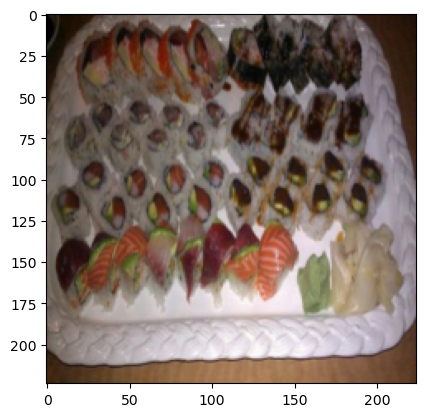

In [5]:
# visualizing a single image to check we got the correct dataloaders
from matplotlib import pyplot as plt

img, label = next(iter(train_dataloader)) # this gives first batch
plt.imshow(img[0].permute(1, 2, 0)) # fist image from that batch

## Replicating Vision Transformer (ViT)

#### Architecture

![](architecture.png)

#### Mathematical Equations
![](equations.png)

__Equation 1:__ <br>
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N = \frac{HW}{P^2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

```python
x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_N] + 
          [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_patch_2_pos]
```

__Equation 2 & Equation 3:__ <br>
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded self- attention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019). <br>


```python
# equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

__Equation 4:__ <br>
Similar to BERT's [{class}] token, we prepend a learnable embedding to the sequence of embedded patches ($\mathbf{z}_0^0 = \mathbf{x}_\text{class}$), whose state at the output of the Transformer encoder ($\mathbf{z}_L^0$) serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

```python
y = Linear_layer(LN_layer(x_output_MLP_block))
```

__Convert Images Into Patches__

In [6]:
height = 224
width = 224
color_channels = 3
patch_size = 16

# calc number of patches
num_of_patches = (height * width) // (patch_size**2)

# input shape
embedding_layer_input_shape = (height, width, color_channels)
# output shape
embedding_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)

print(f"Input Shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output Shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input Shape (single 2D image): (224, 224, 3)
Output Shape (single 1D sequence of patches): (196, 768)


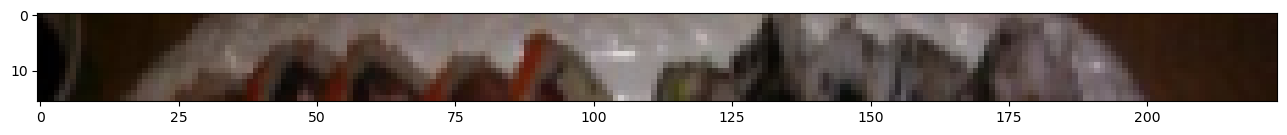

In [7]:
# patches row wise
image_permuted = img[0].permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

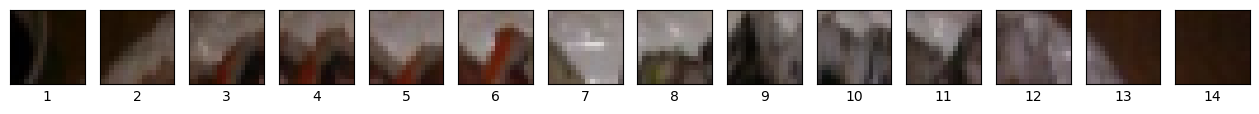

In [8]:
# creating pathces columnwise
img_size = 224
patch_size = 16
num_patches = img_size // patch_size

assert img_size % patch_size == 0

# create a series of subpolots
fig, axs = plt.subplots(nrows=1,
                        ncols= num_patches,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1) # set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

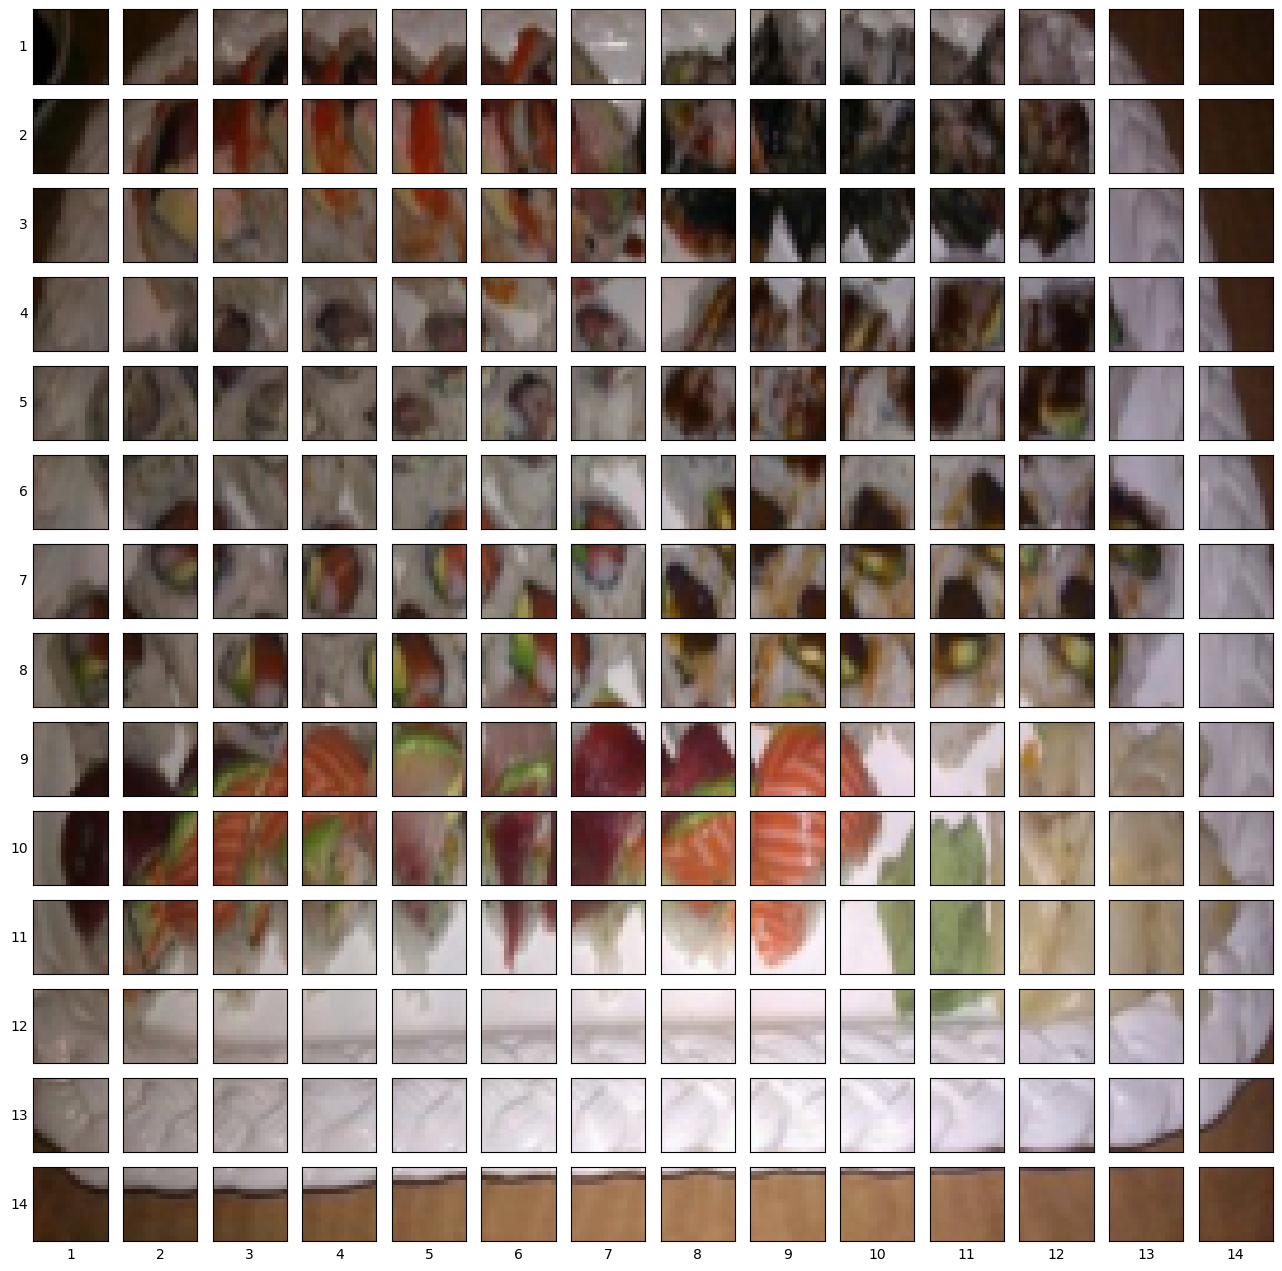

In [9]:
# creating patches rowwise and also columnwise
img_size = 224
patch_size = 16
num_patches = img_size // patch_size

assert img_size % patch_size == 0

# create a grid of subplots
fig, axs = plt.subplots(nrows=num_patches,
                        ncols=num_patches,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

for i, row_patch in enumerate(range(0, img_size, patch_size)):
    for j, col_patch in enumerate(range(0, img_size, patch_size)):
        axs[i][j].imshow(image_permuted[patch_size*i:patch_size*(i+1), 
                                        patch_size*j:patch_size*(j+1), :])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])   
        axs[i][j].set_ylabel(i+1, 
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i][j].set_xlabel(j+1)
        axs[i][j].label_outer()

__Convert patches to embeddings__ <br>
We can convert pathces to embeddings with conv2d layers. We have to set the kernel_size to path_size so that each patch get multiplied with a single kernel and also we can keep the stride to patch_size so that after multiplying one patch the kernel moves to the next patch.

In [12]:
from torch import nn

# set the patch_size
patch_size = 16

# creating a Conv2d layer
conv2d = nn.Conv2d(in_channels=3, # color channels 
                   out_channels=768, # D size (embedding size from Table 1)
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

# pass the image through the conv layer
image_out_of_conv = conv2d(img[0].unsqueeze(0)) # adds batch dimension
print(f"Output Shape: {image_out_of_conv.shape}")

Output Shape: torch.Size([1, 768, 14, 14])
